# Import necessary libraries.

In [1]:
import spacy
import textacy
import textacy.preprocessing
import textacy.resources
#import textacy.keyterms
import textacy.ke
import neuralcoref
from spacy.symbols import ORTH, POS, NOUN, VERB,PRON
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt 
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from networkx.readwrite import json_graph;
import json
from afinn import Afinn
afn = Afinn()
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag
lemmatizer = WordNetLemmatizer()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from allennlp_models.pretrained import load_predictor
predictor = load_predictor("roberta-sst")

visual-entailment is not a registered model.
vqa_vilbert is not a registered model.


downloading:   0%|          | 0/1286605089 [00:00<?, ?B/s]

ModuleNotFoundError: No module named 'sentistrength'

In [3]:
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath('C:/SentiStrength/SentiStrengthCom.jar')
senti.setSentiStrengthLanguageFolderPath('C:/SentiStrength/SentStrength_Data_Sept2011/')
import pandas as pd
from IPython.display import display
import collections
from nltk.corpus import stopwords
set(stopwords.words('english'))
from pd_replicator import replicator

nlp = spacy.load("en_core_web_lg")
neuralcoref.add_to_pipe(nlp)

# Read text file and preprocess.

In [4]:
#from spacy.lang.en import English

file_name = './Text/Simplified Food Insecurity.txt'
#file_name = 'input.txt'
narrative = open(file_name, encoding="utf8").read()

narrative = textacy.preprocessing.normalize_quotation_marks(narrative)
#narrative = textacy.preprocessing.remove_punctuation(narrative, marks=",;:")
#narrative = textacy.preprocessing.normalize_whitespace(narrative)
#narrative = textacy.make_spacy_doc(narrative)
narrative = narrative.lower()
narrative = nlp(narrative)

#narrative._.coref_clusters
#narrative._.coref_resolved

print('Original Narrative:')
print(narrative)
#print('\n')
print('Extracted Coreferences:')
print(narrative._.coref_clusters)
print('\n')
narrative = narrative._.coref_resolved
print('Narrarive after resolving coreferences:')
print(narrative)

raw_sentences = sent_tokenize(narrative)
#nlp.add_pipe(nlp.create_pipe('sentencizer')) # updated
narrative = nlp(narrative)
#sentences = [sent.string.strip() for sent in narrative.sents]
#narrative = nlp(narrative)

print('\nSpacy Sentences:\n')
for sent in narrative.sents:
    print(sent.text)

print('\nNLTK Sentences:\n')
for sent in raw_sentences:
    print(sent)

Original Narrative:
institutional weakness hindered development of the agriculture sector. land rights disagreements are a major source of conflict. this conflict discourages farmers from expanding production. this conflict discourages traders from building marketing infrastructure. this conflict discourages retailers from building marketing infrastructure. the low level of public investment shows that no irrigation infrastructure exists. the low level of public investment shows that only 2 percent of south sudan's limited road network is paved. roads are poorly maintained. roads are not repaired. roads are completely washed out during the rainy season. inadequate transportation infrastructure has resulted in less transport to markets. moderate to heavy rainfall is expected to continue during the next two weeks across sudan moderate to heavy rainfall is expected to continue during the next two weeks across south sudan. moderate to heavy rainfall is expected to continue during the next 

# Extract the Subject-Verb-Object triples.

In [5]:
#new
finalList = []
sentences = []
ncl = []
nncl = [()]
checkPass = False
rootCheck = False
varForm1 = False
varForm2 = False
#tuple =('a','b','c')

#print(tuple[0])

for sent in narrative.sents:
    print("Sentence:")
    print(sent)
    
    print("Noun Chunks:")
    for nc in sent.noun_chunks:
        print (nc)
        ncl.append(nc)
    print ("Number of noun chunks: ", len(ncl))
    
    triplets = textacy.extract.subject_verb_object_triples(sent)
    triplets = list(triplets)
    if len(triplets) > 0:
        print("Triples from textacy:")
        for t in triplets:
            subject = t[0]
            objec = t[2]
            for chunk in ncl:
                for cToken in chunk:
                    if str(cToken) == str(t[0]):
                        subject = chunk
                    if str(cToken) == str(t[2]):
                        objec = chunk
            tup = (subject,t[1],objec)
            print(tup)
            finalList.append(tup)
            sentences.append(sent)
        if len(ncl) == 3:
            nncl = [(ncl[0],triplets[0][1],ncl[1])]
            nncl.append((ncl[0],triplets[0][1],ncl[2]))
            print("Triples other than textacy:")
            print(nncl[0])
            print(nncl[1])
            finalList.append(nncl[0])
            sentences.append(sent)
            finalList.append(nncl[1])
            sentences.append(sent)
#        elif len(ncl) == 2:
#            nncl = [(ncl[0],triplets[0][1],ncl[1])]
#            print("Triples other than textacy:")
#            print(nncl[0])
#            finalList.append(nncl[0])
    else:
        print("Method from textacy; subject_verb_object_triples extracted nothing!")
        for token in sent:
            #print(token.text, token.dep_,)
            if token.dep_ == 'nsubj':
                sub = token
                #tuple[0] = str(token.text)
            elif token.dep_ == 'nsubjpass':
                checkPass = True
                sub = token
            elif token.dep_ == 'ROOT':
                #print("Heyyyyyyy")
                verb = token
                #print(verb)
                rootCheck = True
            elif token.pos_ == 'NOUN' and token.dep_ == 'conj':
                if rootCheck is True:
                    varForm2 = True
                else:
                    varForm1 = True
                #tuple[1] = token.text
            #elif token.dep_ == 'dobj':
            #    obj = token.text
                #tuple[2] = token.text
            #    break
            else:
                if token.dep_ == 'dobj':
                    obj = token
                    continue
                elif token.dep_ == 'pobj':
                    obj = token
                    continue
                
        for nChunk in ncl:
            for nToken in nChunk:
                if str(nToken) == str(sub):
                    sub = nChunk
                if str(nToken) == str(obj):
                    obj = nChunk
        if checkPass is True:
            tuple = (obj,verb,sub)
        else:
            tuple = (sub,verb,obj)
        print("Triple by combining nsubj, root and dobj:")
        print(tuple)
        finalList.append(tuple)
        sentences.append(sent)
        if len(ncl) == 3:
            if varForm1 == True:
                nncl = [(ncl[0],verb,ncl[2])]
                nncl.append((ncl[1],verb,ncl[2]))
                print("Triples other than sub, verb and obj:")
                print(nncl[0])
                print(nncl[1])
                finalList.append(nncl[0])
                sentences.append(sent)
                finalList.append(nncl[1])
                sentences.append(sent)
            else:
                nncl = [(ncl[0],verb,ncl[1])]
                nncl.append((ncl[0],verb,ncl[2]))
                print("Triples other than sub, verb and obj:")
                print(nncl[0])
                print(nncl[1])
                finalList.append(nncl[0])
                sentences.append(sent)
                finalList.append(nncl[1])
                sentences.append(sent)
            
#        elif len(ncl) == 2:
#            nncl = [(ncl[0],verb,ncl[1])]
#            print("Triples other than sub, verb and obj:")
#            print(nncl[0])
#            finalList.append(nncl[0])

    ncl.clear()
    nncl.clear()
    rootCheck = False
    checkPass = False
    varForm1 = False
    varForm2 = False
    
trips = finalList

#        for token in nc:
#            print(token.text, token.dep_)

Sentence:
institutional weakness hindered development of the agriculture sector.
Noun Chunks:
institutional weakness
development
the agriculture sector
Number of noun chunks:  3
Triples from textacy:
(institutional weakness, hindered, development)
Triples other than textacy:
(institutional weakness, hindered, development)
(institutional weakness, hindered, the agriculture sector)
Sentence:
land rights disagreements are a major source of conflict.
Noun Chunks:
land rights disagreements
a major source
conflict
Number of noun chunks:  3
Triples from textacy:
(rights disagreements, are, a major source)
Triples other than textacy:
(land rights disagreements, are, a major source)
(land rights disagreements, are, conflict)
Sentence:
conflict discourages farmers from expanding production.
Noun Chunks:
conflict
farmers
production
Number of noun chunks:  3
Triples from textacy:
(conflict, discourages, farmers)
Triples other than textacy:
(conflict, discourages, farmers)
(conflict, discourages, p

# Print the extracted triples without duplicates.

In [6]:
#causeffect = list(dict.fromkeys(causeffect))

print("Length of triples' List before removing duplicates:")
print(len(trips))


Triples = []

for ce in trips:
    check = False
    #print("ce:")
    #print(ce)
    if len(Triples) == 0:
        #print("HEY!")
        Triples.append(ce)
        #print("added!")
    else:
        for ct in Triples:
            #print("ct:")
            #print(ct)
            if str(ce[0]) == str(ct[0]) and str(ce[1]) == str(ct[1]) and str(ce[2]) == str(ct[2]):
                #print("duplicate")
                check = True
                break;
        if check == False:
            Triples.append(ce)
            #print("added!")

print("\nList after removing duplicates:")
print(len(Triples))

for t in Triples:
    print(t)

Length of triples' List before removing duplicates:
47

List after removing duplicates:
31
(institutional weakness, hindered, development)
(institutional weakness, hindered, the agriculture sector)
(rights disagreements, are, a major source)
(land rights disagreements, are, a major source)
(land rights disagreements, are, conflict)
(conflict, discourages, farmers)
(conflict, discourages, production)
(conflict, discourages, traders)
(conflict, discourages, marketing infrastructure)
(conflict, discourages, retailers)
(no irrigation infrastructure, shows, public investment)
(the low level, shows, public investment)
(the low level, shows, no irrigation infrastructure)
(south sudan's limited road network, shows, only 2 percent)
(south sudan's limited road network, maintained, roads)
(south sudan's limited road network, repaired, roads)
(the rainy season, washed, roads)
(inadequate transportation infrastructure, resulted, markets)
(inadequate transportation infrastructure, resulted, less tra

# Print the extracted triples with sentences.

In [7]:
for sentence, triple  in zip(sentences, trips):
    print(sentence, triple)

institutional weakness hindered development of the agriculture sector. (institutional weakness, hindered, development)
institutional weakness hindered development of the agriculture sector. (institutional weakness, hindered, development)
institutional weakness hindered development of the agriculture sector. (institutional weakness, hindered, the agriculture sector)
land rights disagreements are a major source of conflict. (rights disagreements, are, a major source)
land rights disagreements are a major source of conflict. (land rights disagreements, are, a major source)
land rights disagreements are a major source of conflict. (land rights disagreements, are, conflict)
conflict discourages farmers from expanding production. (conflict, discourages, farmers)
conflict discourages farmers from expanding production. (conflict, discourages, farmers)
conflict discourages farmers from expanding production. (conflict, discourages, production)
conflict discourages traders from building marketing

# Plot the knowledge Graph.

Nodes: 37
Edges: 30
institutional weakness , {'predicate': hindered} , development
institutional weakness , {'predicate': hindered} , the agriculture sector
rights disagreements , {'predicate': are} , a major source
land rights disagreements , {'predicate': are} , a major source
land rights disagreements , {'predicate': are} , conflict
conflict , {'predicate': discourages} , farmers
conflict , {'predicate': discourages} , production
conflict , {'predicate': discourages} , traders
conflict , {'predicate': discourages} , marketing infrastructure
conflict , {'predicate': discourages} , retailers
no irrigation infrastructure , {'predicate': shows} , public investment
the low level , {'predicate': shows} , public investment
the low level , {'predicate': shows} , no irrigation infrastructure
south sudan's limited road network , {'predicate': shows} , only 2 percent
south sudan's limited road network , {'predicate': repaired} , roads
the rainy season , {'predicate': washed} , roads
inadequate

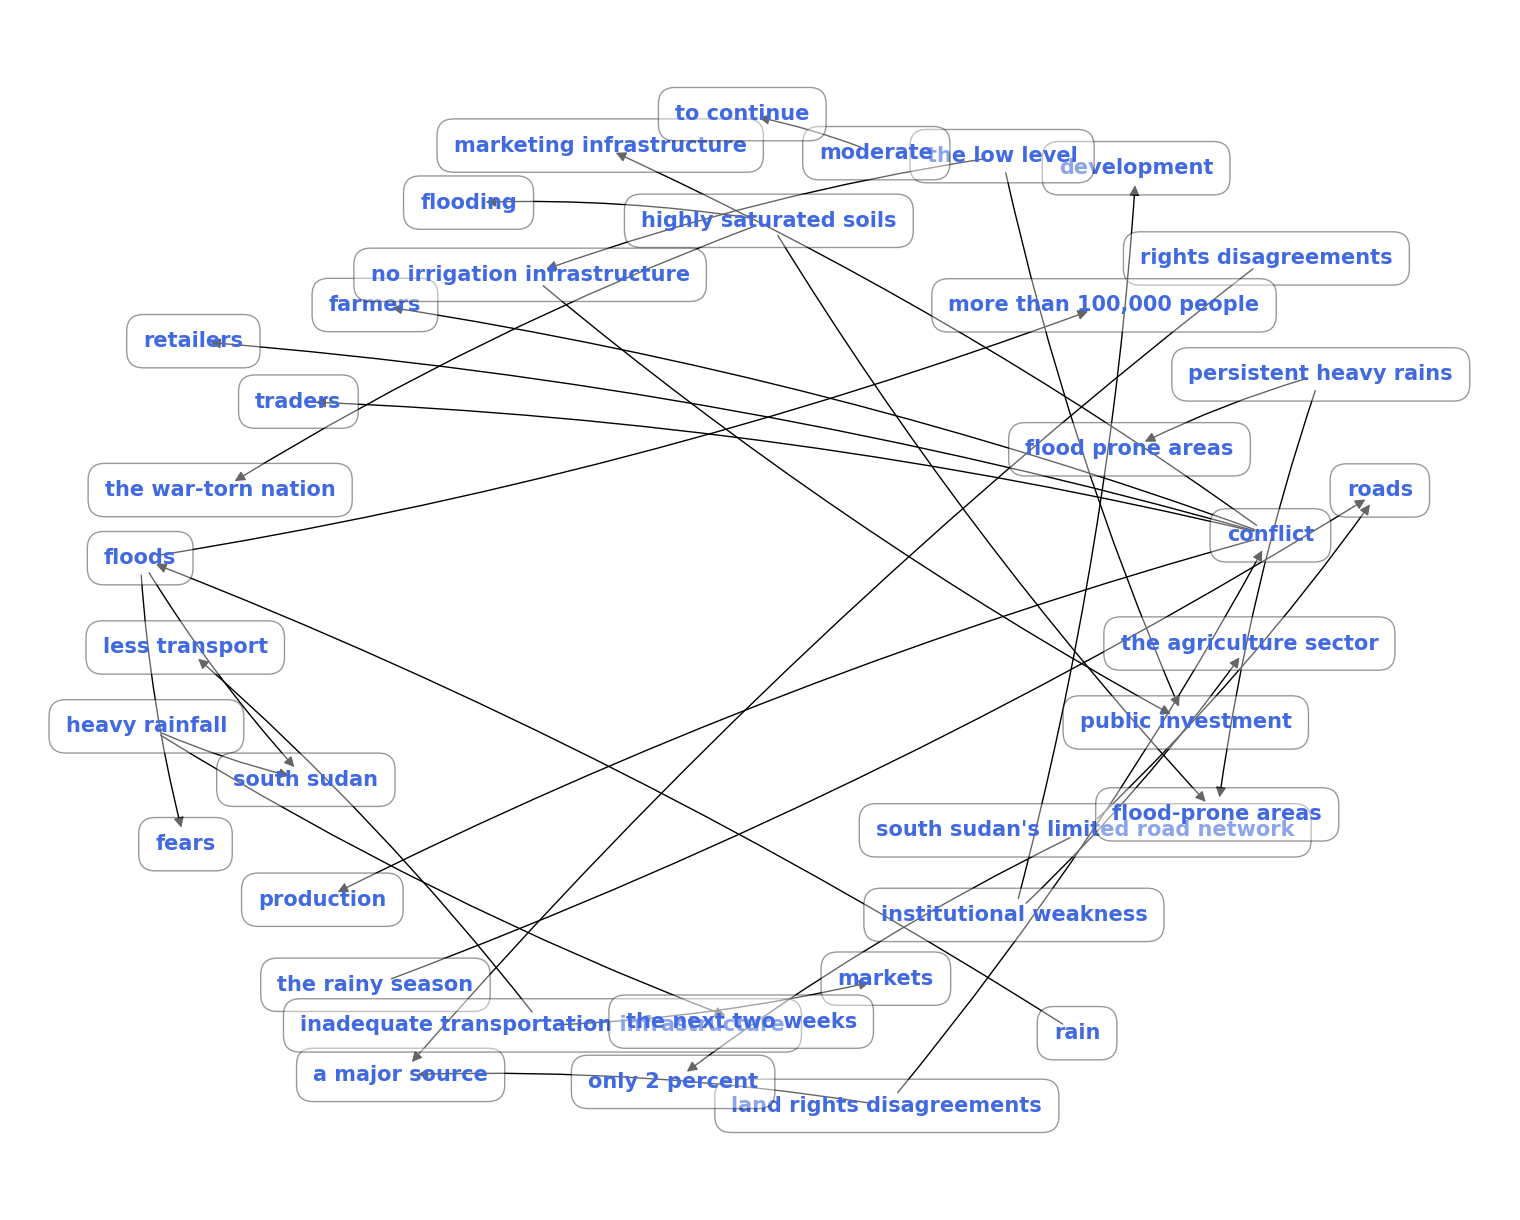

In [8]:
cmap = nx.DiGraph()

for triple in trips:
    s = str(triple[0])    
    d = str(triple[2])
    cmap.add_edge(s, d, predicate=triple[1])
    #print(triple)

print("Nodes:",len(cmap.nodes))
print("Edges:",len(cmap.edges))
for e in cmap.edges(data=True):
    print(e[0],",",e[2],",",e[1])

pos = nx.spring_layout(cmap, k=4, iterations=20)
plt.figure(figsize=(15,12))

nx.draw(cmap, pos=pos, with_labels=True,  connectionstyle='arc3, rad = 0.05', node_shape="s",  node_color="none", font_size=15,  font_color='royalblue', font_weight='bold',bbox=dict(facecolor="white", alpha=0.4,boxstyle='round,pad=0.8'),labels={node: node for node in cmap.nodes()},arrows=True, arrowsize=15,width=1)
edge_labels = nx.get_edge_attributes(cmap,'predicade')
nx.draw_networkx_edge_labels(cmap, pos=pos, edge_labels = edge_labels, font_color='black',font_size=13)

plt.axis('off')
plt.show()

# Dump the Knowledge Graph on "Knowledge Graph.json" 

In [6]:
knowledgeGraph = nx.DiGraph()

for svo in trips:
    s = str(svo[0])    
    d = str(svo[2])
    knowledgeGraph.add_node(s,id = str(s),title=str(s),x=615,y=200)
    knowledgeGraph.add_node(d,id = str(d),title=str(d),x=615,y=200)
    knowledgeGraph.add_edge(s, d, predicade=str(svo[1]))

#print(len(knowledgeGraph.nodes))
#print(len(knowledgeGraph.edges))

data = json_graph.node_link_data(knowledgeGraph)


out_file = open("./Json Graphs/Knowledge Graph.json", "w")
  
json.dump(data, out_file, indent = 6)
  
out_file.close()

# Create Causal Trigger Words Dictionary along with their synonyms.

In [13]:
#new

causalWords1 = ["forced","caused", "resulted", "reason", "as a result of", "as a consequence of", 
               "consequence", "consequently", "affect", "because", "increase", "decrease","due to","because of"
               ,"made","minimize","maximize","hindered", "displaced", "conspired","led to","activate","impel","inspire",
                "excite","quicken","rouse","stimulate","influence","determine","likely","probable","disconnected","separated"
                ,"excluded","after","as","since","trigger","oppose","fight","provides","strengthened","launched","develop"
               ,"guarantees","declared", "developed","produced","discourages","demotivated","encouraged","motivated"]

#causalWords1 = ["develop"]
synonyms1 = []
lemma_function = WordNetLemmatizer()

for cw1 in causalWords1:
    #print(cw1)
    synonyms1.append(cw1.lower())
    tokens1 = word_tokenize(cw1)
    for token1, tag1 in pos_tag(tokens1):
        lemma1 = lemma_function.lemmatize(token1)
        #print(token1,lemma1)
        
        for syn in wordnet.synsets(str(lemma1)):
            
            for l1 in syn.lemmas():
                #print(l1)
                #synonyms1.append(lemma1.lower())
                synonyms1.append(l1.name().lower())
                #print(l1)
                for syn1 in wordnet.synsets(str(l1.name())):
                    for l2 in syn1.lemmas():
                        #print(l2)
                        synonyms1.append(l2.name().lower())
            

#remove duplicates from synonyms1
synonyms = []
     
for synonym in synonyms1:
    if synonym not in synonyms:
        synonyms.append(synonym)
    
#for x in synonyms:
#    print (synonym)

print(len(synonyms))

3226


# Writing causal trigger words dictionary to text file (dictionary.txt)

In [16]:
#synonyms
output_file = open('.\dictionary.txt', 'w')

for syn in synonyms:
    #print(syn)
    output_file.write(syn + '\n')

output_file.close()

# Reading causal trigger words dictionary from text file (dictionary.txt) to list 

In [9]:
synonyms = []

my_file = open(".\dictionary.txt", "r")
  
data = my_file.read()
  
synonyms = data.split("\n")
#print(data_into_list)
my_file.close()

print(len(synonyms))

3227


# Filter Causal triples along with their causal sentences from SVO triples based upon causal trigger words dictionary.

In [11]:
causeffect = [] #without duplicates
causalSentences = [] #with duplicates
#lem = []
lemma_function = WordNetLemmatizer()
for s,st in zip(sentences,trips):
    check = False
    #st = (str(st[0]),str(st[1]),str(st[2]))
    #synonym = synonym[0]
    tokens = word_tokenize(str(st[1]))
    for token, tag in pos_tag(tokens):
        lemma = lemma_function.lemmatize(token)
        #print(token,lemma)
        #st[1] = lemma
        #lem.append(lemma)
        
    for synonym in synonyms:
        if synonym == lemma:
            #causeffect = [(st[0],st[1],st[2])]
            #strTriples.append((ncl[0],token.text,st[2]))
           # print(st)
            if len(causeffect) == 0:
                causeffect.append(st)
                causalSentences.append(s)
            else:
                for ct in causeffect:
                    if str(st[0]) == str(ct[0]) and str(st[1]) == str(ct[1]) and str(st[2]) == str(ct[2]):
                        check = True
                        break;
                if check == False:
                    causeffect.append(st)
                    causalSentences.append(s)
            #if (len(causeffect) >0 ) and (st in causeffect == False):
                
            #    causeffect.append(st)
            break
    
#causeffect.sort(key = lambda x: x[0])

#for sortedTriple in causeffect:
#    print(sortedTriple)
print(len(causalSentences))
print(len(causeffect))
for causalSentence, causalTriple  in zip(causalSentences, causeffect):
    print(causalSentence, causalTriple)

21
21
institutional weakness hindered development of the agriculture sector. (institutional weakness, hindered, development)
institutional weakness hindered development of the agriculture sector. (institutional weakness, hindered, the agriculture sector)
conflict discourages farmers from expanding production. (conflict, discourages, farmers)
conflict discourages farmers from expanding production. (conflict, discourages, production)
conflict discourages traders from building marketing infrastructure. (conflict, discourages, traders)
conflict discourages traders from building marketing infrastructure. (conflict, discourages, marketing infrastructure)
conflict discourages retailers from building marketing infrastructure. (conflict, discourages, retailers)
the low level of public investment shows that no irrigation infrastructure exists. (no irrigation infrastructure, shows, public investment)
the low level of public investment shows that no irrigation infrastructure exists. (the low level

# Plot the Causal Graph.

Nodes: 27
Edges: 21
institutional weakness , {'predicade': 'hindered'} , development
institutional weakness , {'predicade': 'hindered'} , the agriculture sector
conflict , {'predicade': 'discourages'} , farmers
conflict , {'predicade': 'discourages'} , production
conflict , {'predicade': 'discourages'} , traders
conflict , {'predicade': 'discourages'} , marketing infrastructure
conflict , {'predicade': 'discourages'} , retailers
no irrigation infrastructure , {'predicade': 'shows'} , public investment
the low level , {'predicade': 'shows'} , public investment
the low level , {'predicade': 'shows'} , no irrigation infrastructure
south sudan's limited road network , {'predicade': 'shows'} , only 2 percent
inadequate transportation infrastructure , {'predicade': 'resulted'} , markets
inadequate transportation infrastructure , {'predicade': 'resulted'} , less transport
persistent heavy rains , {'predicade': 'cause'} , flood prone areas
persistent heavy rains , {'predicade': 'cause'} , floo

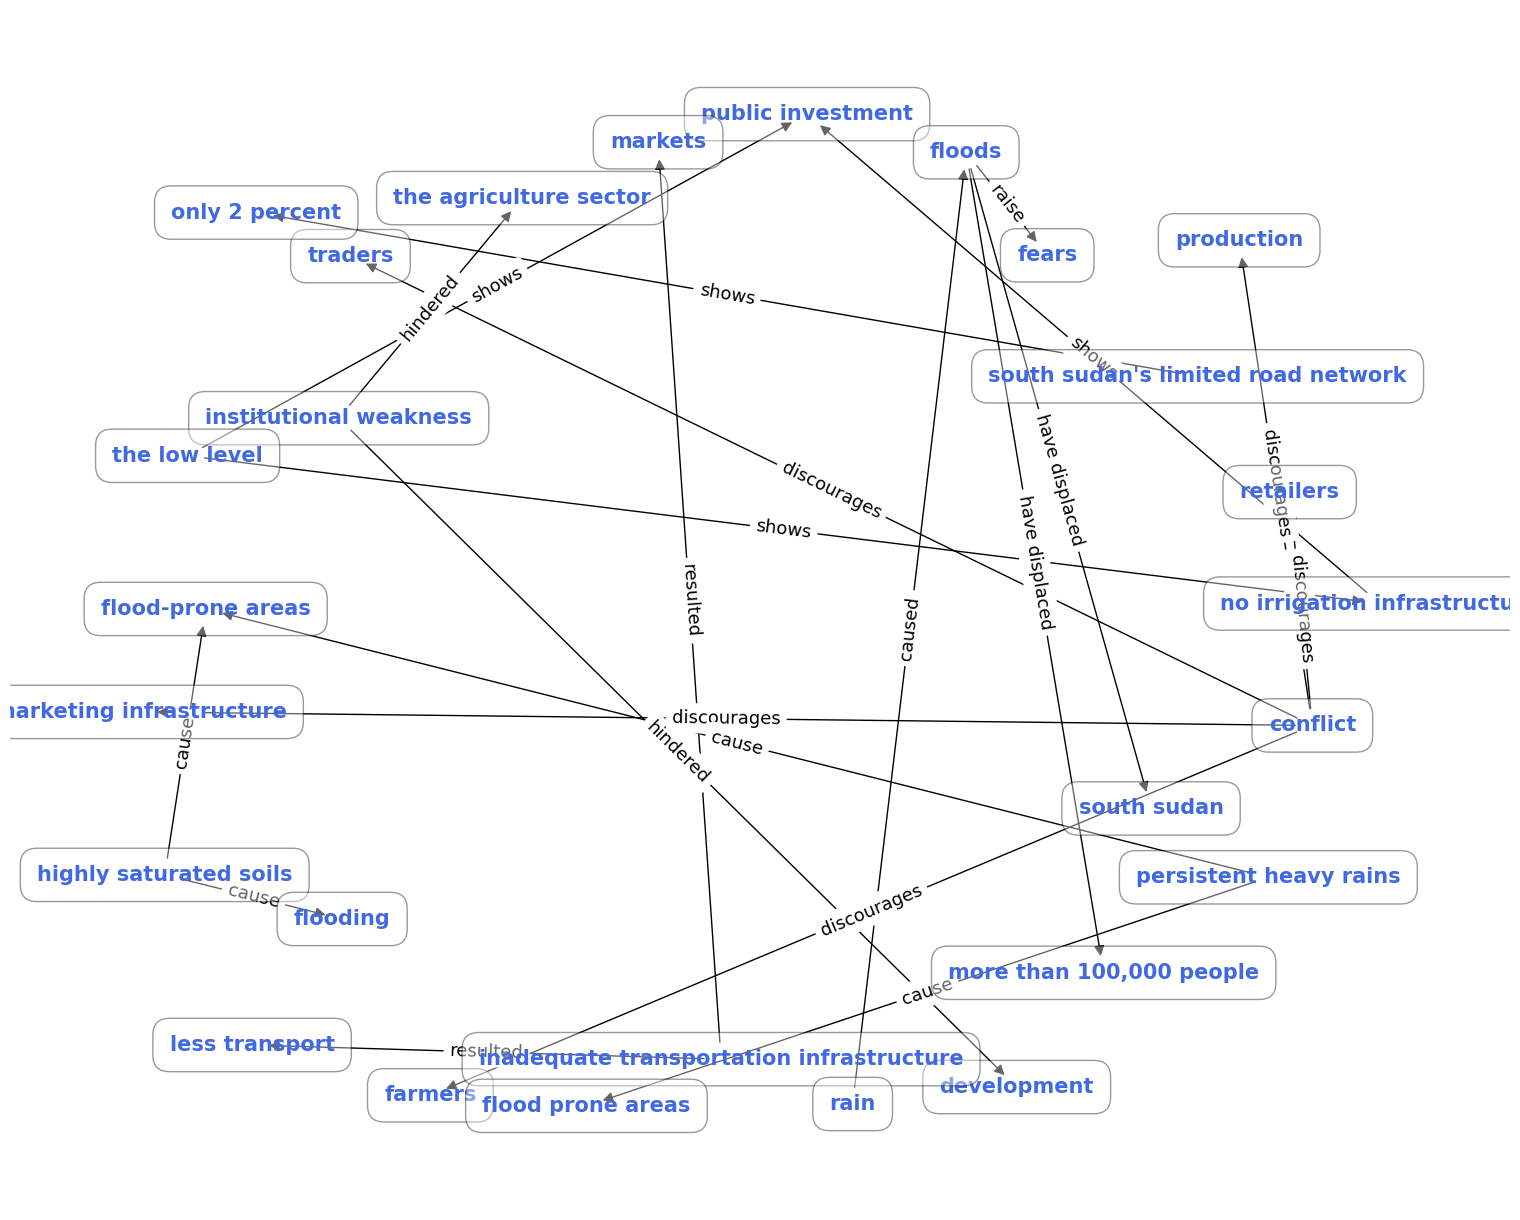

In [12]:
#new (DAG Implementation)
#without duplicates
dagCauseTriples = []
cg = nx.DiGraph()

for ce in causeffect:
    s = str(ce[0])    
    d = str(ce[2])
    #cg.add_node(s,id = str(s),title=str(s),x=615,y=200) #for d3js
    cg.add_node(s,id = str(s),title=str(s),x=615,y=200)
    #cg.add_node(d,id = str(d),title=str(d),x=615,y=200) #for d3js
    cg.add_node(d,id = str(d),title=str(d),x=615,y=200)
    cg.add_edge(s, d, predicade=str(ce[1]))
    dagCauseTriples.append(ce)
    if nx.is_directed_acyclic_graph(cg) is False:
        cg.remove_edge(s, d)
        dagCauseTriples.remove(ce)
        

print("Nodes:",len(cg.nodes))
print("Edges:",len(cg.edges))
for e in cg.edges(data=True):
    print(e[0],",",e[2],",",e[1])

pos = nx.spring_layout(cg, k=4, iterations=20)
plt.figure(figsize=(15,12))

nx.draw(cg, pos=pos, with_labels=True,  node_shape="s",  node_color="none", font_size=15,  font_color='royalblue', font_weight='bold',bbox=dict(facecolor="white", alpha=0.4,boxstyle='round,pad=0.8'),labels={node: node for node in cg.nodes()},arrows=True, arrowsize=15,width=1)
edge_labels = nx.get_edge_attributes(cg,'predicade')
nx.draw_networkx_edge_labels(cmap, pos=pos, edge_labels = edge_labels, font_color='black',font_size=13)

plt.axis('off')
plt.show()

Nodes: 5
Edges: 5
excessive overthinking , {'predicade': 'leads'} , insomnia
insomnia , {'predicade': 'causes'} , stress
stress , {'predicade': 'results'} , insomnia
overthinking , {'predicade': 'can increase'} , anxiety
overthinking , {'predicade': 'can cause'} , insomnia
False


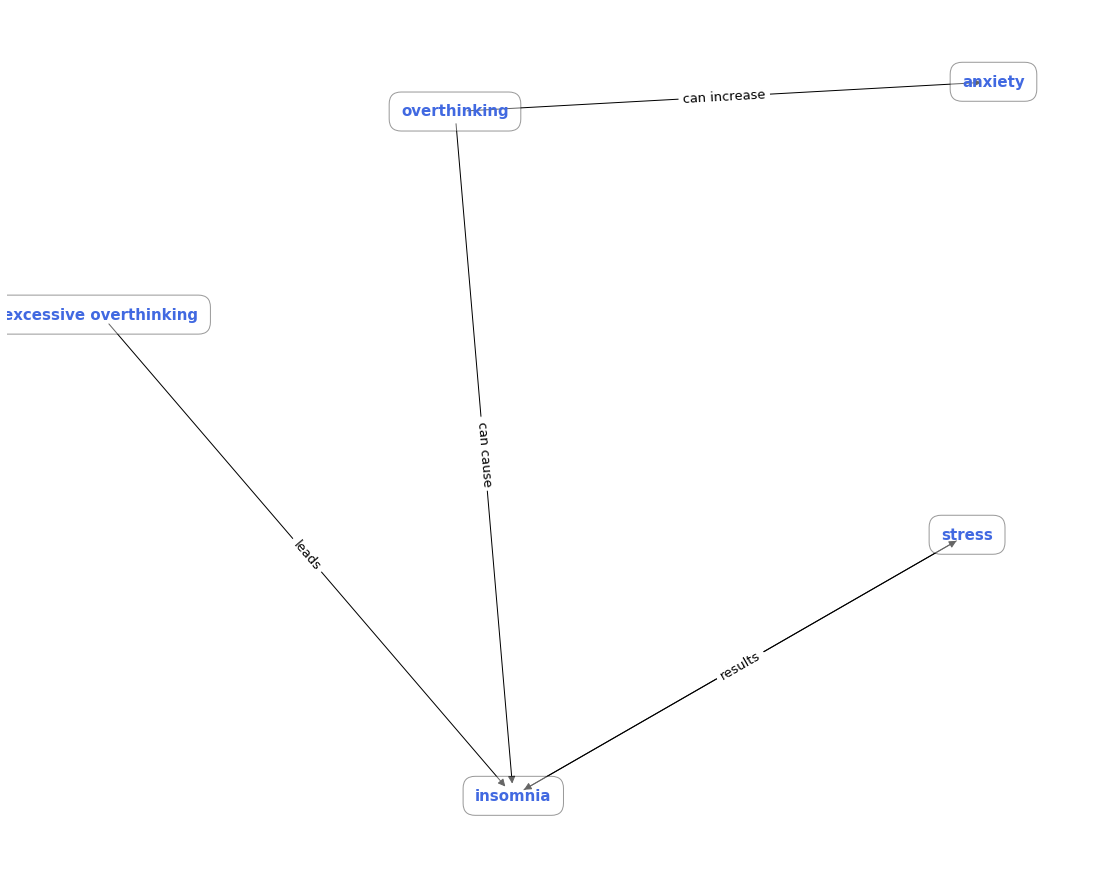

In [56]:
#old
#without duplicates

cg = nx.DiGraph()

for ce in causeffect:
    s = str(ce[0])    
    d = str(ce[2])
    #cg.add_node(s,id = str(s),title=str(s),x=615,y=200) #for d3js
    cg.add_node(s,id = str(s),title=str(s),x=615,y=200)
    #cg.add_node(d,id = str(d),title=str(d),x=615,y=200) #for d3js
    cg.add_node(d,id = str(d),title=str(d),x=615,y=200)
    cg.add_edge(s, d, predicade=str(ce[1]))
        

print("Nodes:",len(cg.nodes))
print("Edges:",len(cg.edges))
for e in cg.edges(data=True):
    print(e[0],",",e[2],",",e[1])
    
print(nx.is_directed_acyclic_graph(cg))

pos = nx.spring_layout(cg, k=4, iterations=20)
plt.figure(figsize=(15,12))

nx.draw(cg, pos=pos, with_labels=True,  node_shape="s",  node_color="none", font_size=15,  font_color='royalblue', font_weight='bold',bbox=dict(facecolor="white", alpha=0.4,boxstyle='round,pad=0.8'),labels={node: node for node in cg.nodes()},arrows=True, arrowsize=15,width=1)
edge_labels = nx.get_edge_attributes(cg,'predicade')
nx.draw_networkx_edge_labels(cmap, pos=pos, edge_labels = edge_labels, font_color='black',font_size=13)

plt.axis('off')
plt.show()

# Plot the Causal Graph on using Pyvis "Causal Graph.html" file 

In [18]:
nt = Network("500px", "1000px", notebook=True,directed=True, bgcolor='#ffffff', font_color='black', layout=None, heading='Causal Graph')

for dm in dagCauseTriples:
    #color = "#ffffff"
    nt.add_node(str(dm[0]),shape = 'box',physics='false',color = "#ffffff")
    nt.add_node(str(dm[2]),shape = 'box',physics='false',color = "#ffffff")
    nt.add_edge(str(dm[0]),str(dm[2]),label=str(dm[1]), weight=10, physics='false',color='black')

#nt.show_buttons(filter_=['physics'])
nt.set_edge_smooth('discrete')
nt.show("./Pyvis Graph/Causal Graph.html")

# Dump the Causal Graph on "Causal Graph.json" file 

In [10]:
data = json_graph.node_link_data(cg)


out_file = open("./Json Graphs/Causal Graph.json", "w")
  
json.dump(data, out_file, indent = 6)
  
out_file.close()

# Remove Duplicates from Causal Triples

In [16]:
#causeffect = list(dict.fromkeys(causeffect))

print("List before removing duplicates:")
print(len(causeffect))

for t in causeffect:
    print(t)
    
causalTriples = []

for ce in causeffect:
    check = False
    #print("ce:")
    #print(ce)
    if len(causalTriples) == 0:
        #print("HEY!")
        causalTriples.append(ce)
        #print("added!")
    else:
        for ct in causalTriples:
            #print("ct:")
            #print(ct)
            if str(ce[0]) == str(ct[0]) and str(ce[1]) == str(ct[1]) and str(ce[2]) == str(ct[2]):
                #print("duplicate")
                check = True
                break;
        if check == False:
            causalTriples.append(ce)
            #print("added!")

print("\nList after removing duplicates:")
print(len(causalTriples))

for t in causalTriples:
    print(t)

List before removing duplicates:
6
(nuclear bomb, makes, nuclear power)
(pakistan, must never surrender, nuclear bomb)
(pakistan, must fight, existential threats)
(pakistan, must support, army)
(pakistan, must support, aq khan)
(army, guards, nuclear bomb)

List after removing duplicates:
6
(nuclear bomb, makes, nuclear power)
(pakistan, must never surrender, nuclear bomb)
(pakistan, must fight, existential threats)
(pakistan, must support, army)
(pakistan, must support, aq khan)
(army, guards, nuclear bomb)


# Remove Duplicates from causalSentences

In [11]:
#causalSentences = list(dict.fromkeys(causalSentences))
#causalSentences = list(set(causalSentences))
print("List before removing duplicates:")
print(len(causalSentences))

for t in causalSentences:
    print(t)
    
causalSentencesNoDup = []

for ce in causalSentences:
    check = False
    #print("ce:")
    #print(ce)
    if len(causalSentencesNoDup) == 0:
        #print("HEY!")
        causalSentencesNoDup.append(ce)
        #print("added!")
    else:
        for ct in causalSentencesNoDup:
            #print("ct:")
            #print(ct)
            if str(ce) == str(ct):
                #print("duplicate")
                check = True
                break;
        if check == False:
            causalSentencesNoDup.append(ce)
            #print("added!")

print("\nList after removing duplicates:")
print(len(causalSentencesNoDup))

for t in causalSentencesNoDup:
    print(t)

List before removing duplicates:
19
institutional weakness hindered development of the agriculture sector.
institutional weakness hindered development of the agriculture sector.
the low level of public investment shows that no irrigation infrastructure exists.
the low level of public investment shows that no irrigation infrastructure exists.
the low level of public investment shows that no irrigation infrastructure exists.
the low level of public investment shows that only 2 percent of south sudan's limited road network is paved.
inadequate transportation infrastructure has resulted in less transport to markets.
inadequate transportation infrastructure has resulted in less transport to markets.
persistent heavy rains in the ethiopian highlands cause flooding in flood prone areas.
persistent heavy rains in the ethiopian highlands cause flooding in flood prone areas.
persistent heavy rains in the ethiopian highlands cause flooding in flood prone areas.
persistent heavy rains in south sud

# Causal Triples' Polarity (Whole) 

### [AllenNlp] 

In [12]:
#https://demo.allennlp.org/sentiment-analysis/roberta-sentiment-analysis
#https://paperswithcode.com/model/roberta-large-sst

#output (Pos,neg)

#sentence = "Enemies surround Pakistan."
#preds = predictor.predict(sentence)
#print(f"p(positive)={preds['probs'][0]:.2%}")
allen = []
for sent in causalTriples:
    #print(sent)
    preds = predictor.predict(str(sent))
    #print(preds['label'][0])
    label = preds['label'][0]
    if label is '0':
        allen.append(-1)
    else:
        allen.append(1)
    
for causalSentence, polarity  in zip(causalTriples, allen):
    print(causalSentence, polarity)

(institutional weakness, hindered, development) -1
(institutional weakness, hindered, the agriculture sector) -1
(no irrigation infrastructure, shows, public investment) -1
(the low level, shows, public investment) -1
(the low level, shows, no irrigation infrastructure) -1
(south sudan's limited road network, shows, only 2 percent) -1
(inadequate transportation infrastructure, resulted, markets) -1
(inadequate transportation infrastructure, resulted, less transport) -1
(persistent heavy rains, cause, flooding) -1
(persistent heavy rains, cause, the ethiopian highlands) -1
(persistent heavy rains, cause, flood prone areas) -1
(persistent heavy rains, cause, flood-prone areas) -1
(highly saturated soils, cause, flooding) -1
(rain, caused, floods) -1
(floods, have displaced, more than 100,000 people) -1
(floods, have displaced, south sudan) -1
(floods, raise, fears) -1
(floods, impact, south sudan) 1
(floods, impact, food security) 1


### [Afinn]

In [13]:
#https://www.geeksforgeeks.org/python-sentiment-analysis-using-affin/

#output (Pos,neg,neural)

afinn = []
for sent in causalTriples:
    #print(str(sent))
    score = afn.score(str(sent))
    #print(score)
    if score > 0:
        #print('positive')
        afinn.append(1)
    elif score < 0:
        #print('negative')
        afinn.append(-1)
    else:
        #print('neutral')
        afinn.append(0)
        
for causalSentence, polarity  in zip(causalTriples, afinn):
    print(causalSentence, polarity)

(institutional weakness, hindered, development) -1
(institutional weakness, hindered, the agriculture sector) -1
(no irrigation infrastructure, shows, public investment) -1
(the low level, shows, public investment) 0
(the low level, shows, no irrigation infrastructure) -1
(south sudan's limited road network, shows, only 2 percent) -1
(inadequate transportation infrastructure, resulted, markets) -1
(inadequate transportation infrastructure, resulted, less transport) -1
(persistent heavy rains, cause, flooding) 0
(persistent heavy rains, cause, the ethiopian highlands) 0
(persistent heavy rains, cause, flood prone areas) 0
(persistent heavy rains, cause, flood-prone areas) 0
(highly saturated soils, cause, flooding) 0
(rain, caused, floods) 0
(floods, have displaced, more than 100,000 people) 0
(floods, have displaced, south sudan) 0
(floods, raise, fears) 0
(floods, impact, south sudan) 0
(floods, impact, food security) 0


### [Vader]

In [14]:
#https://github.com/cjhutto/vaderSentiment#about-the-scoring
#output (Pos,neg,neural)

vader = []

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    #print(vs)
    return vs['compound']

def vader_analysis(compound):
    if compound >= 0.05:
        vader.append(1)
        return 'Positive'
    elif compound <= -0.05 :
        vader.append(-1)
        return 'Negative'
        
    elif  compound > -0.05 and compound < 0.05:
        vader.append(0)
        return 'Neutral'
    
for sent in causalTriples:
    #print(sent)
    compound = vadersentimentanalysis(str(sent))
    vader_analysis(compound)
    
for causalSentence, polarity  in zip(causalTriples, vader):
    print(causalSentence, polarity)

(institutional weakness, hindered, development) -1
(institutional weakness, hindered, the agriculture sector) -1
(no irrigation infrastructure, shows, public investment) 0
(the low level, shows, public investment) -1
(the low level, shows, no irrigation infrastructure) -1
(south sudan's limited road network, shows, only 2 percent) -1
(inadequate transportation infrastructure, resulted, markets) -1
(inadequate transportation infrastructure, resulted, less transport) -1
(persistent heavy rains, cause, flooding) 0
(persistent heavy rains, cause, the ethiopian highlands) 0
(persistent heavy rains, cause, flood prone areas) 0
(persistent heavy rains, cause, flood-prone areas) 0
(highly saturated soils, cause, flooding) 0
(rain, caused, floods) 0
(floods, have displaced, more than 100,000 people) 0
(floods, have displaced, south sudan) 0
(floods, raise, fears) -1
(floods, impact, south sudan) 0
(floods, impact, food security) 1


### [SentiStrength]

In [15]:
#http://sentistrength.wlv.ac.uk/
#http://paper.ijcsns.org/07_book/202001/20200107.pdf
#https://pypi.org/project/sentistrength/
#http://sentistrength.wlv.ac.uk/results.php?text=pakistan+must+support+army+and+aq+khan.&submit=Detect+Sentiment&result=trinary
#https://professorkhan.com/2019/03/29/sentiment-analysis-with-sentistrength/
#output (Pos,neg)

sentiStrength = []

for sent in causalTriples:
    #print(sent)
    result = senti.getSentiment(str(sent), score='binary')
    #print(result)
    
    if result[0]==1:
        #print('Positive')
        sentiStrength.append(1)
    elif result[0]==-1:
        sentiStrength.append(-1)
        #print('Negative')
    #else:
    #    print('Neutral')

for causalSentence, polarity  in zip(causalTriples, sentiStrength):
    print(causalSentence, polarity)

(institutional weakness, hindered, development) -1
(institutional weakness, hindered, the agriculture sector) -1
(no irrigation infrastructure, shows, public investment) 1
(the low level, shows, public investment) -1
(the low level, shows, no irrigation infrastructure) -1
(south sudan's limited road network, shows, only 2 percent) 1
(inadequate transportation infrastructure, resulted, markets) -1
(inadequate transportation infrastructure, resulted, less transport) -1
(persistent heavy rains, cause, flooding) 1
(persistent heavy rains, cause, the ethiopian highlands) 1
(persistent heavy rains, cause, flood prone areas) 1
(persistent heavy rains, cause, flood-prone areas) 1
(highly saturated soils, cause, flooding) 1
(rain, caused, floods) 1
(floods, have displaced, more than 100,000 people) -1
(floods, have displaced, south sudan) -1
(floods, raise, fears) -1
(floods, impact, south sudan) 1
(floods, impact, food security) 1


### Data Frame (Causal Triples Whole)

In [16]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

df2 = pd.DataFrame(list(zip(causalTriples, allen, afinn, vader,sentiStrength)), columns =['Causal Triple', 'AllenNLP','Afinn','Vader','SentiStrength'])
df2["Weight"] = df2.sum(axis=1)

sentPolarity = []
triplesWeight_sentLevel = []

for index, row in df2.iterrows():
    tripleWeightTuple = []
    weight = row['Weight']
    tripleWeightTuple.append(weight)
    triplesWeight_sentLevel.append(tripleWeightTuple)
    #print(weight)
    if weight is -4:
        sentPolarity.append('Strong Negative') 
        #print('Strong Negative')
    elif weight is -3:
        sentPolarity.append('Moderate Negative')
        #print('Moderate Negative')
    elif weight is -2:
        sentPolarity.append('Mild Negative')
        #print('Mild Negative')
    elif weight is -1:
        sentPolarity.append('Weak Negative')
        #print('Weak Negative')
    elif weight is 0:
        sentPolarity.append('Neutral')
        #print('Neutral')
    elif weight is 4:
        sentPolarity.append('Strong Positive')
        #print('Strong Positive')
    elif weight is 3:
        sentPolarity.append('Moderate Positive')
        #print('Moderate Positive')
    elif weight is 2:
        sentPolarity.append('Mild Positive')
        #print('Mild Positive')
    elif weight is 1:
        sentPolarity.append('Weak Positive')
        #print('Weak Positive')

df2["Polarity"] = sentPolarity
df2.style

,Causal Triple,AllenNLP,Afinn,Vader,SentiStrength,Weight,Polarity
0,"(institutional weakness, hindered, development)",-1,-1,-1,-1,-4,Strong Negative
1,"(institutional weakness, hindered, the agriculture sector)",-1,-1,-1,-1,-4,Strong Negative
2,"(no irrigation infrastructure, shows, public investment)",-1,-1,0,1,-1,Weak Negative
3,"(the low level, shows, public investment)",-1,0,-1,-1,-3,Moderate Negative
4,"(the low level, shows, no irrigation infrastructure)",-1,-1,-1,-1,-4,Strong Negative
5,"(south sudan's limited road network, shows, only 2 percent)",-1,-1,-1,1,-2,Mild Negative
6,"(inadequate transportation infrastructure, resulted, markets)",-1,-1,-1,-1,-4,Strong Negative
7,"(inadequate transportation infrastructure, resulted, less transport)",-1,-1,-1,-1,-4,Strong Negative
8,"(persistent heavy rains, cause, flooding)",-1,0,0,1,0,Neutral
9,"(persistent heavy rains, cause, the ethiopian highlands)",-1,0,0,1,0,Neutral


# Causal Sentences' Polarity (Whole) 

### [AllenNlp] 

In [17]:
#https://demo.allennlp.org/sentiment-analysis/roberta-sentiment-analysis
#https://paperswithcode.com/model/roberta-large-sst

#output (Pos,neg)

#sentence = "Enemies surround Pakistan."
#preds = predictor.predict(sentence)
#print(f"p(positive)={preds['probs'][0]:.2%}")
def Allen_sents_SentLevel(causalSentences):
    allen = []
    for sent in causalSentences:
        #print(sent)
        preds = predictor.predict(str(sent))
        #print(preds['label'][0])
        label = preds['label'][0]
        if label is '0':
            allen.append(-1)
        else:
            allen.append(1)
    return allen

#for causalSentence, polarity  in zip(causalSentences, allen):
#    print(causalSentence, polarity)

### [Afinn]

In [18]:
#https://www.geeksforgeeks.org/python-sentiment-analysis-using-affin/

#output (Pos,neg,neural)
def Afinn_sents_SentLevel(causalSentences):
    afinn = []
    for sent in causalSentences:
        #print(sent)
        score = afn.score(str(sent))
        #print(score)
        if score > 0:
            #print('positive')
            afinn.append(1)
        elif score < 0:
            #print('negative')
            afinn.append(-1)
        else:
            #print('neutral')
            afinn.append(0)
    return afinn

#for causalSentence, polarity  in zip(causalSentences, afinn):
#    print(causalSentence, polarity)

### [Vader]

In [19]:
#https://github.com/cjhutto/vaderSentiment#about-the-scoring
#output (Pos,neg,neural)

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    #print(vs)
    return vs['compound']

def vader_analysis(compound):
    #vader = []
    if compound >= 0.05:
        #vader.append(1)
        return 1
    elif compound <= -0.05 :
        #vader.append(-1)
        return -1
        
    elif  compound > -0.05 and compound < 0.05:
        #vader.append(0)
        return 0
    #return vader
    
def Vader_sents_SentLevel(causalSentences):
    vader = []
    for sent in causalSentences:
        #print(sent)
        #vaderTup = []
        compound = vadersentimentanalysis(str(sent))
        res = vader_analysis(compound)
        #vaderTup.append(res)
        vader.append(res)
    return vader

#vader = Vader_sents_SentLevel(causalSents)
#vader
#for causalSentence, polarity  in zip(causalSentences, vader):
#    print(causalSentence, polarity)

### [SentiStrength]

In [20]:
#http://sentistrength.wlv.ac.uk/
#http://paper.ijcsns.org/07_book/202001/20200107.pdf
#https://pypi.org/project/sentistrength/
#http://sentistrength.wlv.ac.uk/results.php?text=pakistan+must+support+army+and+aq+khan.&submit=Detect+Sentiment&result=trinary
#https://professorkhan.com/2019/03/29/sentiment-analysis-with-sentistrength/
#output (Pos,neg)

def Senti_sents_SentLevel(causalSentences):
    sentiStrength = []
    for sent in causalSentences:
        #print(sent)
        result = senti.getSentiment(str(sent), score='binary')
        #print(result)
    
        if result[0]==1:
            #print('Positive')
            sentiStrength.append(1)
        elif result[0]==-1:
            sentiStrength.append(-1)
            #print('Negative')
        #else:
        #    print('Neutral')
    return sentiStrength

#for causalSentence, polarity  in zip(causalSentences, sentiStrength):
#    print(causalSentence, polarity)

### [SentiWordnet]

### [SentiWordNet OnlyVerbs]

### Detect Causal Sentences' Polarity (Sent Level) without duplicates

In [21]:
causalSents = causalSentencesNoDup
print(len(causalSents))

11


### Detect Causal Sentences' Polarity (Sent Level) with duplicates

### Data Frame (Causal Sentence at Sentence Level)

In [22]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

allen = Allen_sents_SentLevel(causalSents)
afinn = Afinn_sents_SentLevel(causalSents)
vader = Vader_sents_SentLevel(causalSents)
sentiStrength = Senti_sents_SentLevel(causalSents)

df2 = pd.DataFrame(list(zip(causalSents, allen, afinn, vader,sentiStrength)), columns =['Causal Sentence', 'AllenNLP','Afinn','Vader','SentiStrength'])
df2["Weight"] = df2.sum(axis=1)


sentPolarity = []
sentsWeight_sentLevel = []

for index, row in df2.iterrows():
    sentWeightTuple = []
    weight = row['Weight']
    sentWeightTuple.append(weight)
    sentsWeight_sentLevel.append(sentWeightTuple)
    #print(weight)
    if weight is -4:
        sentPolarity.append('Strong Negative') 
        #print('Strong Negative')
    elif weight is -3:
        sentPolarity.append('Moderate Negative')
        #print('Moderate Negative')
    elif weight is -2:
        sentPolarity.append('Mild Negative')
        #print('Mild Negative')
    elif weight is -1:
        sentPolarity.append('Weak Negative')
        #print('Weak Negative')
    elif weight is 0:
        sentPolarity.append('Neutral')
        #print('Neutral')
    elif weight is 4:
        sentPolarity.append('Strong Positive')
        #print('Strong Positive')
    elif weight is 3:
        sentPolarity.append('Moderate Positive')
        #print('Moderate Positive')
    elif weight is 2:
        sentPolarity.append('Mild Positive')
        #print('Mild Positive')
    elif weight is 1:
        sentPolarity.append('Weak Positive')
        #print('Weak Positive')

df2["Polarity"] = sentPolarity
df2.style

,Causal Sentence,AllenNLP,Afinn,Vader,SentiStrength,Weight,Polarity
0,institutional weakness hindered development of the agriculture sector.,-1,-1,-1,-1,-4,Strong Negative
1,the low level of public investment shows that no irrigation infrastructure exists.,-1,-1,-1,-1,-4,Strong Negative
2,the low level of public investment shows that only 2 percent of south sudan's limited road network is paved.,-1,-1,-1,-1,-4,Strong Negative
3,inadequate transportation infrastructure has resulted in less transport to markets.,-1,-1,-1,-1,-4,Strong Negative
4,persistent heavy rains in the ethiopian highlands cause flooding in flood prone areas.,-1,0,0,1,0,Neutral
5,persistent heavy rains in south sudan cause flooding in flood-prone areas.,-1,0,0,1,0,Neutral
6,highly saturated soils cause flooding in flood-prone areas.,-1,0,0,1,0,Neutral
7,rain caused floods.,-1,0,0,1,0,Neutral
8,"floods have displaced more than 100,000 people in south sudan.",-1,0,0,-1,-2,Mild Negative
9,floods raise fears.,-1,0,-1,-1,-3,Moderate Negative


# Causal Triples' Polarity (Token Level) 

### [AllenNlp] 

In [23]:
allen_word = []
allen_tuple = []

for tokenTuple in causalTriples:
    #print(tokenTuple)
    for token in tokenTuple:
        #if str(token) not in marks: 
        #print(token)
        preds = predictor.predict(str(token))
            #print(preds['label'][0])
        label = preds['label'][0]
        if label is '0':
            allen_tuple.append(-1)
                #allen_word.append(-1)
        else:
                #allen_word.append(1)
            allen_tuple.append(1)
    allen_word.append(allen_tuple)
    allen_tuple = []
                
for a,b in zip(causalTriples,allen_word):
    #print(len(a))
    print(a,b)

(institutional weakness, hindered, development) [-1, -1, 1]
(institutional weakness, hindered, the agriculture sector) [-1, -1, 1]
(no irrigation infrastructure, shows, public investment) [-1, 1, 1]
(the low level, shows, public investment) [-1, 1, 1]
(the low level, shows, no irrigation infrastructure) [-1, 1, -1]
(south sudan's limited road network, shows, only 2 percent) [-1, 1, -1]
(inadequate transportation infrastructure, resulted, markets) [-1, 1, 1]
(inadequate transportation infrastructure, resulted, less transport) [-1, 1, -1]
(persistent heavy rains, cause, flooding) [-1, 1, -1]
(persistent heavy rains, cause, the ethiopian highlands) [-1, 1, 1]
(persistent heavy rains, cause, flood prone areas) [-1, 1, -1]
(persistent heavy rains, cause, flood-prone areas) [-1, 1, -1]
(highly saturated soils, cause, flooding) [1, 1, -1]
(rain, caused, floods) [-1, 1, 1]
(floods, have displaced, more than 100,000 people) [1, -1, 1]
(floods, have displaced, south sudan) [1, -1, 1]
(floods, ra

### [Afinn] 

In [24]:
afinn_word = []
afinn_tuple = []

for tokenTuple in causalTriples:
    #print(sent)
    for token in tokenTuple:
        #if str(token) != ".": #or str(token) != ',' or str(token) != "-":
        #if str(token) not in marks:
            #print(token)
        score = afn.score(str(token))
        if score > 0:
                #print('positive')
            afinn_tuple.append(1)
        elif score < 0:
                #print('negative')
            afinn_tuple.append(-1)
        else:
                #print('neutral')
            afinn_tuple.append(0)
    afinn_word.append(afinn_tuple)
    afinn_tuple = []

for a,b in zip(causalTriples,afinn_word):
   # print(len(a))
    print(a,b)

(institutional weakness, hindered, development) [-1, 0, 0]
(institutional weakness, hindered, the agriculture sector) [-1, 0, 0]
(no irrigation infrastructure, shows, public investment) [-1, 0, 0]
(the low level, shows, public investment) [0, 0, 0]
(the low level, shows, no irrigation infrastructure) [0, 0, -1]
(south sudan's limited road network, shows, only 2 percent) [-1, 0, 0]
(inadequate transportation infrastructure, resulted, markets) [-1, 0, 0]
(inadequate transportation infrastructure, resulted, less transport) [-1, 0, 0]
(persistent heavy rains, cause, flooding) [0, 0, 0]
(persistent heavy rains, cause, the ethiopian highlands) [0, 0, 0]
(persistent heavy rains, cause, flood prone areas) [0, 0, 0]
(persistent heavy rains, cause, flood-prone areas) [0, 0, 0]
(highly saturated soils, cause, flooding) [0, 0, 0]
(rain, caused, floods) [0, 0, 0]
(floods, have displaced, more than 100,000 people) [0, 0, 0]
(floods, have displaced, south sudan) [0, 0, 0]
(floods, raise, fears) [0, 0

### [Vader] 

In [25]:
vader_word = []
vader_tuple = []

for tokenTuple in causalTriples:
    #print(sent)
    for token in tokenTuple:
        #if str(token) not in marks:
        vs = analyzer.polarity_scores(str(token))
        compound = vs['compound']
        if compound >= 0.05:
            vader_tuple.append(1)   
        elif compound <= -0.05 :
            vader_tuple.append(-1)
        elif  compound > -0.05 and compound < 0.05:
            vader_tuple.append(0)
    vader_word.append(vader_tuple)
    vader_tuple = []

for a,b in zip(causalTriples,vader_word):
    #print(len(a))
    print(a,b)

(institutional weakness, hindered, development) [-1, 0, 0]
(institutional weakness, hindered, the agriculture sector) [-1, 0, 0]
(no irrigation infrastructure, shows, public investment) [-1, 0, 0]
(the low level, shows, public investment) [-1, 0, 0]
(the low level, shows, no irrigation infrastructure) [-1, 0, -1]
(south sudan's limited road network, shows, only 2 percent) [-1, 0, 0]
(inadequate transportation infrastructure, resulted, markets) [-1, 0, 0]
(inadequate transportation infrastructure, resulted, less transport) [-1, 0, 0]
(persistent heavy rains, cause, flooding) [0, 0, 0]
(persistent heavy rains, cause, the ethiopian highlands) [0, 0, 0]
(persistent heavy rains, cause, flood prone areas) [0, 0, 0]
(persistent heavy rains, cause, flood-prone areas) [0, 0, 0]
(highly saturated soils, cause, flooding) [0, 0, 0]
(rain, caused, floods) [0, 0, 0]
(floods, have displaced, more than 100,000 people) [0, 0, 0]
(floods, have displaced, south sudan) [0, 0, 0]
(floods, raise, fears) [0,

### [SentiStrength] 

In [26]:
senti_word = []
senti_tuple = []

for tokenTuple in causalTriples:
    #print(tokenTuple)
    for token in tokenTuple:
        #if str(token) not in marks:
        #print(token)
        result = senti.getSentiment(str(token), score='binary')
            #print(result)
        if result[0]==1:
                #print('Positive')
            senti_tuple.append(1)
        elif result[0]==-1:
                #print('Negative')
            senti_tuple.append(-1)
        else:
                #print('Neutral')
            senti_tuple.append(0)
    senti_word.append(senti_tuple)
    senti_tuple = []
    
for a,b in zip(causalTriples,senti_word):
    #print(len(a))
    print(a,b)

(institutional weakness, hindered, development) [-1, 1, 1]
(institutional weakness, hindered, the agriculture sector) [-1, 1, 1]
(no irrigation infrastructure, shows, public investment) [1, 1, 1]
(the low level, shows, public investment) [-1, 1, 1]
(the low level, shows, no irrigation infrastructure) [-1, 1, 1]
(south sudan's limited road network, shows, only 2 percent) [1, 1, 1]
(inadequate transportation infrastructure, resulted, markets) [-1, 1, 1]
(inadequate transportation infrastructure, resulted, less transport) [-1, 1, 1]
(persistent heavy rains, cause, flooding) [1, 1, 1]
(persistent heavy rains, cause, the ethiopian highlands) [1, 1, 1]
(persistent heavy rains, cause, flood prone areas) [1, 1, 1]
(persistent heavy rains, cause, flood-prone areas) [1, 1, 1]
(highly saturated soils, cause, flooding) [1, 1, 1]
(rain, caused, floods) [1, 1, 1]
(floods, have displaced, more than 100,000 people) [1, -1, 1]
(floods, have displaced, south sudan) [1, -1, 1]
(floods, raise, fears) [1, 

### Data Frame (Causal Triples Token Level)

In [27]:
from pd_replicator import replicator

sum_list = []
sum_tup = []
limit= len(causalTriples)

#print(limit)
for i in range(0,limit):
    #dataframe_WordLevel(i)
    #print(len(allen_word[i]))
    for j in range(0,len(allen_word[i])):
        res = allen_word[i][j]+afinn_word[i][j]+vader_word[i][j]+senti_word[i][j]
        #print(res)
        sum_tup.append(res)
    sum_list.append(sum_tup)
    sum_tup = []
    
def DetectPolarity(sum_list):
    tokenPolarity = []
    tokenPolarity_list = []
    for s in sum_list:
        for weight in s:
            if weight >= -4.0 and weight < -3.0:
                tokenPolarity.append('Strong Negative') 
            elif weight >= -3 and weight < -2:
                tokenPolarity.append('Moderate Negative')
            elif weight >= -2 and weight < -1:
                tokenPolarity.append('Mild Negative')
            elif weight >= -1 and weight < 0:
                tokenPolarity.append('Weak Negative')
            elif weight == 0:
                tokenPolarity.append('Neutral')
            elif weight <= 4 and weight > 3:
                tokenPolarity.append('Strong Positive')
            elif weight <= 3 and weight > 2:
                tokenPolarity.append('Moderate Positive')
            elif weight <= 2 and weight > 1:
                tokenPolarity.append('Mild Positive')
            elif weight <= 1 and weight > 0:
                tokenPolarity.append('Weak Positive')
        tokenPolarity_list.append(tokenPolarity)
        tokenPolarity = []
    return tokenPolarity_list

tokenPolarity_list = DetectPolarity(sum_list)

triplesWeight_TokenLevel = []
weightSumTup = []
for t in sum_list:
    tripleWeight = 0
    total = len(t)
    #print(total)
    for w in t:
        tripleWeight = tripleWeight + w
    tripleWeight = round(tripleWeight/total, 2)
    weightSumTup.append(tripleWeight)
    triplesWeight_TokenLevel.append(weightSumTup)
    weightSumTup = []

triplePolarity_list = DetectPolarity(triplesWeight_TokenLevel)

#Old algorithm that detects triples' polarity by counting the token polarities with highest frequency
#maxPolarity = []
#triplePolarity_list = []
#for t in tokenPolarity_list:
#    counter=collections.Counter(t)
#    maxPolarity.append(counter.most_common(1)[0][0])
#    triplePolarity_list.append(maxPolarity)
#    maxPolarity = []


def dataframe_WordLevel(i):
    df = pd.DataFrame([causalTriples[i],allen_word[i],afinn_word[i],vader_word[i],senti_word[i],sum_list[i],tokenPolarity_list[i],triplesWeight_TokenLevel[i],triplePolarity_list[i]], 
                      index =   ['Tokens','AllenNlp','Afinn','Vader','SentiStrength','Token Weight','Token Polarity','Triple Weight','Triple Polarity'])
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    return df

for i in range(0,limit):
    df = dataframe_WordLevel(i)
    #df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
    #display(df)
    #df.to_excel(r'./Text/output.xlsx', index = False)
    replicator(df)

#for s,w,p in zip(sum_list,weightSum,triplePolarity_list):
#    print(s,w,p)

,0,1,2
Tokens,"(institutional, weakness)",(hindered),(development)
AllenNlp,-1,-1,1
Afinn,-1,0,0
Vader,-1,0,0
SentiStrength,-1,1,1
Token Weight,-4,0,2
Token Polarity,Strong Negative,Neutral,Mild Positive
Triple Weight,-0.67,None,None
Triple Polarity,Weak Negative,None,None


,0,1,2
Tokens,"(institutional, weakness)",(hindered),"(the, agriculture, sector)"
AllenNlp,-1,-1,1
Afinn,-1,0,0
Vader,-1,0,0
SentiStrength,-1,1,1
Token Weight,-4,0,2
Token Polarity,Strong Negative,Neutral,Mild Positive
Triple Weight,-0.67,None,None
Triple Polarity,Weak Negative,None,None


,0,1,2
Tokens,"(no, irrigation, infrastructure)",shows,"(public, investment)"
AllenNlp,-1,1,1
Afinn,-1,0,0
Vader,-1,0,0
SentiStrength,1,1,1
Token Weight,-2,2,2
Token Polarity,Mild Negative,Mild Positive,Mild Positive
Triple Weight,0.67,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,"(the, low, level)",shows,"(public, investment)"
AllenNlp,-1,1,1
Afinn,0,0,0
Vader,-1,0,0
SentiStrength,-1,1,1
Token Weight,-3,2,2
Token Polarity,Moderate Negative,Mild Positive,Mild Positive
Triple Weight,0.33,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,"(the, low, level)",shows,"(no, irrigation, infrastructure)"
AllenNlp,-1,1,-1
Afinn,0,0,-1
Vader,-1,0,-1
SentiStrength,-1,1,1
Token Weight,-3,2,-2
Token Polarity,Moderate Negative,Mild Positive,Mild Negative
Triple Weight,-1,None,None
Triple Polarity,Weak Negative,None,None


,0,1,2
Tokens,"(south, sudan, 's, limited, road, network)",shows,"(only, 2, percent)"
AllenNlp,-1,1,-1
Afinn,-1,0,0
Vader,-1,0,0
SentiStrength,1,1,1
Token Weight,-2,2,0
Token Polarity,Mild Negative,Mild Positive,Neutral
Triple Weight,0,None,None
Triple Polarity,Neutral,None,None


,0,1,2
Tokens,"(inadequate, transportation, infrastructure)",resulted,(markets)
AllenNlp,-1,1,1
Afinn,-1,0,0
Vader,-1,0,0
SentiStrength,-1,1,1
Token Weight,-4,2,2
Token Polarity,Strong Negative,Mild Positive,Mild Positive
Triple Weight,0,None,None
Triple Polarity,Neutral,None,None


,0,1,2
Tokens,"(inadequate, transportation, infrastructure)",resulted,"(less, transport)"
AllenNlp,-1,1,-1
Afinn,-1,0,0
Vader,-1,0,0
SentiStrength,-1,1,1
Token Weight,-4,2,0
Token Polarity,Strong Negative,Mild Positive,Neutral
Triple Weight,-0.67,None,None
Triple Polarity,Weak Negative,None,None


,0,1,2
Tokens,"(persistent, heavy, rains)",(cause),(flooding)
AllenNlp,-1,1,-1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,0,2,0
Token Polarity,Neutral,Mild Positive,Neutral
Triple Weight,0.67,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,"(persistent, heavy, rains)",(cause),"(the, ethiopian, highlands)"
AllenNlp,-1,1,1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,0,2,2
Token Polarity,Neutral,Mild Positive,Mild Positive
Triple Weight,1.33,None,None
Triple Polarity,Mild Positive,None,None


,0,1,2
Tokens,"(persistent, heavy, rains)",(cause),"(flood, prone, areas)"
AllenNlp,-1,1,-1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,0,2,0
Token Polarity,Neutral,Mild Positive,Neutral
Triple Weight,0.67,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,"(persistent, heavy, rains)",cause,"(flood, -, prone, areas)"
AllenNlp,-1,1,-1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,0,2,0
Token Polarity,Neutral,Mild Positive,Neutral
Triple Weight,0.67,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,"(highly, saturated, soils)",(cause),(flooding)
AllenNlp,1,1,-1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,2,2,0
Token Polarity,Mild Positive,Mild Positive,Neutral
Triple Weight,1.33,None,None
Triple Polarity,Mild Positive,None,None


,0,1,2
Tokens,(rain),(caused),(floods)
AllenNlp,-1,1,1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,0,2,2
Token Polarity,Neutral,Mild Positive,Mild Positive
Triple Weight,1.33,None,None
Triple Polarity,Mild Positive,None,None


,0,1,2
Tokens,(floods),"(have, displaced)","(more, than, 100,000, people)"
AllenNlp,1,-1,1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,-1,1
Token Weight,2,-2,2
Token Polarity,Mild Positive,Mild Negative,Mild Positive
Triple Weight,0.67,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,(floods),"(have, displaced)","(south, sudan)"
AllenNlp,1,-1,1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,-1,1
Token Weight,2,-2,2
Token Polarity,Mild Positive,Mild Negative,Mild Positive
Triple Weight,0.67,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,(floods),(raise),(fears)
AllenNlp,1,1,-1
Afinn,0,0,0
Vader,0,0,-1
SentiStrength,1,1,-1
Token Weight,2,2,-3
Token Polarity,Mild Positive,Mild Positive,Moderate Negative
Triple Weight,0.33,None,None
Triple Polarity,Weak Positive,None,None


,0,1,2
Tokens,(floods),impact,"(south, sudan)"
AllenNlp,1,1,1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,2,2,2
Token Polarity,Mild Positive,Mild Positive,Mild Positive
Triple Weight,2,None,None
Triple Polarity,Mild Positive,None,None


,0,1,2
Tokens,(floods),impact,"(food, security)"
AllenNlp,1,1,1
Afinn,0,0,0
Vader,0,0,1
SentiStrength,1,1,1
Token Weight,2,2,3
Token Polarity,Mild Positive,Mild Positive,Moderate Positive
Triple Weight,2.33,None,None
Triple Polarity,Moderate Positive,None,None


# Causal Sentences' Polarity (Token Level) 

### Generating list of tokens without stop words and punctuation marks.

In [28]:
def GenerateTokens(causalSentences):
    marks = ['.',',','(',')','-',':',';','/',"'s",'_','__','--','"', '’', '—']
    token_list = []
   
    for sent in causalSentences:
        token_tuple = []
        for token in sent:
            if str(token) not in marks:
                if str(token) not in stopwords.words():
                    token_tuple.append(str(token))
        token_list.append(token_tuple)
    return token_list
        
#print(len(token_list))
#print(token_list)

### [AllenNlp] 

In [29]:
def Allen_sents_TokenLevel(token_list):
    allen_word = []
    allen_tuple = []
    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) not in marks: 
                #print(token)
            preds = predictor.predict(str(token))
                #print(preds['label'][0])
            label = preds['label'][0]
            if label is '0':
                allen_tuple.append(-1)
                    #allen_word.append(-1)
            else:
                    #allen_word.append(1)
                allen_tuple.append(1)
        allen_word.append(allen_tuple)
        allen_tuple = []
    return allen_word

#for a in allen_word:
#    print(len(a))
#    print(a)

### [Afinn] 

In [30]:
def Afinn_sents_TokenLevel(token_list):
    afinn_word = []
    afinn_tuple = []

    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) != ".": #or str(token) != ',' or str(token) != "-":
            #if str(token) not in marks:
                #print(token)
            score = afn.score(str(token))
            if score > 0:
                    #print('positive')
                afinn_tuple.append(1)
            elif score < 0:
                    #print('negative')
                afinn_tuple.append(-1)
            else:
                    #print('neutral')
                afinn_tuple.append(0)
        afinn_word.append(afinn_tuple)
        afinn_tuple = []
    return afinn_word

#for a in afinn_word:
#    print(len(a))
#    print(a)

### [Vader] 

In [31]:
def Vader_sents_TokenLevel(token_list):
    vader_word = []
    vader_tuple = []

    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) not in marks:
            vs = analyzer.polarity_scores(str(token))
            compound = vs['compound']
            if compound >= 0.05:
                vader_tuple.append(1)   
            elif compound <= -0.05 :
                vader_tuple.append(-1)
            elif  compound > -0.05 and compound < 0.05:
                vader_tuple.append(0)
        vader_word.append(vader_tuple)
        vader_tuple = []
    return vader_word

#for a in vader_word:
#    print(len(a))
#    print(a)

### [SentiStrength] 

In [32]:
def Senti_sents_TokenLevel(token_list):
    senti_word = []
    senti_tuple = []
    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) not in marks:
                #print(token)
            result = senti.getSentiment(str(token), score='binary')
                #print(result)
            if result[0]==1:
                    #print('Positive')
                senti_tuple.append(1)
            elif result[0]==-1:
                    #print('Negative')
                senti_tuple.append(-1)
            else:
                    #print('Neutral')
                senti_tuple.append(0)
        senti_word.append(senti_tuple)
        senti_tuple = []
    return senti_word
    
#for a in senti_word:
#    print(len(a))
#    print(a)

### Data Frame (Causal Sentences Word Level)

In [33]:
token_list = GenerateTokens(causalSents)
allen_word = Allen_sents_TokenLevel(token_list)
afinn_word = Afinn_sents_TokenLevel(token_list)
vader_word = Vader_sents_TokenLevel(token_list)   
senti_word = Senti_sents_TokenLevel(token_list)

sum_list = []
sum_tup = []
limit= len(causalSents)

#print(limit)
for i in range(0,limit):
    #dataframe_WordLevel(i)
    #print(len(allen_word[i]))
    for j in range(0,len(allen_word[i])):
        res = allen_word[i][j]+afinn_word[i][j]+vader_word[i][j]+senti_word[i][j]
        #print(res)
        sum_tup.append(res)
    sum_list.append(sum_tup)
    sum_tup = []
    
def DetectPolarity(sum_list):
    tokenPolarity = []
    tokenPolarity_list = []
    for s in sum_list:
        for weight in s:
            if weight >= -4.0 and weight < -3.0:
                tokenPolarity.append('Strong Negative') 
            elif weight >= -3 and weight < -2:
                tokenPolarity.append('Moderate Negative')
            elif weight >= -2 and weight < -1:
                tokenPolarity.append('Mild Negative')
            elif weight >= -1 and weight < 0:
                tokenPolarity.append('Weak Negative')
            elif weight == 0:
                tokenPolarity.append('Neutral')
            elif weight <= 4 and weight > 3:
                tokenPolarity.append('Strong Positive')
            elif weight <= 3 and weight > 2:
                tokenPolarity.append('Moderate Positive')
            elif weight <= 2 and weight > 1:
                tokenPolarity.append('Mild Positive')
            elif weight <= 1 and weight > 0:
                tokenPolarity.append('Weak Positive')
        tokenPolarity_list.append(tokenPolarity)
        tokenPolarity = []
    return tokenPolarity_list

tokenPolarity_list = DetectPolarity(sum_list)

sentsWeight_TokenLevel = []
weightSumTup = []
for t in sum_list:
    tripleWeight = 0
    total = len(t)
    #print(total)
    for w in t:
        tripleWeight = tripleWeight + w
    tripleWeight = round(tripleWeight/total, 2)
    weightSumTup.append(tripleWeight)
    sentsWeight_TokenLevel.append(weightSumTup)
    weightSumTup = []

SentencePolarity_list = DetectPolarity(sentsWeight_TokenLevel)

#Old algorithm that detects triples' polarity by counting the token polarities with highest frequency
#maxPolarity = []
#triplePolarity_list = []
#for t in tokenPolarity_list:
#    counter=collections.Counter(t)
#    maxPolarity.append(counter.most_common(1)[0][0])
#    triplePolarity_list.append(maxPolarity)
#    maxPolarity = []


def dataframe_WordLevel(i):
    df = pd.DataFrame([token_list[i],allen_word[i],afinn_word[i],vader_word[i],senti_word[i],sum_list[i],tokenPolarity_list[i],sentsWeight_TokenLevel[i],SentencePolarity_list[i]], 
                      index =   ['Tokens','AllenNlp','Afinn','Vader','SentiStrength','Token Weight','Token Polarity','Sentence Weight','Sentence Polarity'])
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    return df

for i in range(0,limit):
    df = dataframe_WordLevel(i)
    #df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
    #display(df)
    #df.to_excel(r'./Text/output.xlsx', index = False)
    replicator(df)

#for s,w,p in zip(sum_list,weightSum,triplePolarity_list):
#    print(s,w,p)

,0,1,2,3,4,5
Tokens,institutional,weakness,hindered,development,agriculture,sector
AllenNlp,1,-1,-1,1,1,1
Afinn,0,-1,0,0,0,0
Vader,0,-1,0,0,0,0
SentiStrength,1,-1,1,1,1,1
Token Weight,2,-4,0,2,2,2
Token Polarity,Mild Positive,Strong Negative,Neutral,Mild Positive,Mild Positive,Mild Positive
Sentence Weight,0.67,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None


,0,1,2,3,4,5,6,7
Tokens,low,level,public,investment,shows,irrigation,infrastructure,exists
AllenNlp,-1,1,1,1,1,-1,1,1
Afinn,0,0,0,0,0,0,0,0
Vader,-1,0,0,0,0,0,0,0
SentiStrength,-1,1,1,1,1,1,1,1
Token Weight,-3,2,2,2,2,0,2,2
Token Polarity,Moderate Negative,Mild Positive,Mild Positive,Mild Positive,Mild Positive,Neutral,Mild Positive,Mild Positive
Sentence Weight,1.12,None,None,None,None,None,None,None
Sentence Polarity,Mild Positive,None,None,None,None,None,None,None


,0,1,2,3,4,5,6,7,8,9,10,11,12
Tokens,low,level,public,investment,shows,2,percent,south,sudan,limited,road,network,paved
AllenNlp,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,1
Afinn,0,0,0,0,0,0,0,0,0,-1,0,0,0
Vader,-1,0,0,0,0,0,0,0,0,-1,0,0,0
SentiStrength,-1,1,1,1,1,1,1,1,1,1,1,1,1
Token Weight,-3,2,2,2,2,2,2,0,0,-2,0,2,2
Token Polarity,Moderate Negative,Mild Positive,Mild Positive,Mild Positive,Mild Positive,Mild Positive,Mild Positive,Neutral,Neutral,Mild Negative,Neutral,Mild Positive,Mild Positive
Sentence Weight,0.85,None,None,None,None,None,None,None,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None,None,None,None,None,None,None,None


,0,1,2,3,4,5,6
Tokens,inadequate,transportation,infrastructure,resulted,less,transport,markets
AllenNlp,-1,1,1,1,-1,1,1
Afinn,-1,0,0,0,0,0,0
Vader,-1,0,0,0,0,0,0
SentiStrength,-1,1,1,1,1,1,1
Token Weight,-4,2,2,2,0,2,2
Token Polarity,Strong Negative,Mild Positive,Mild Positive,Mild Positive,Neutral,Mild Positive,Mild Positive
Sentence Weight,0.86,None,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None,None


,0,1,2,3,4,5,6,7,8,9
Tokens,persistent,heavy,rains,ethiopian,highlands,cause,flooding,flood,prone,areas
AllenNlp,1,-1,-1,1,1,1,-1,-1,-1,1
Afinn,0,0,0,0,0,0,0,0,0,0
Vader,0,0,0,0,0,0,0,0,0,0
SentiStrength,1,1,1,1,1,1,1,1,1,1
Token Weight,2,0,0,2,2,2,0,0,0,2
Token Polarity,Mild Positive,Neutral,Neutral,Mild Positive,Mild Positive,Mild Positive,Neutral,Neutral,Neutral,Mild Positive
Sentence Weight,1,None,None,None,None,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None,None,None,None,None


,0,1,2,3,4,5,6,7,8,9
Tokens,persistent,heavy,rains,south,sudan,cause,flooding,flood,prone,areas
AllenNlp,1,-1,-1,-1,-1,1,-1,-1,-1,1
Afinn,0,0,0,0,0,0,0,0,0,0
Vader,0,0,0,0,0,0,0,0,0,0
SentiStrength,1,1,1,1,1,1,1,1,1,1
Token Weight,2,0,0,0,0,2,0,0,0,2
Token Polarity,Mild Positive,Neutral,Neutral,Neutral,Neutral,Mild Positive,Neutral,Neutral,Neutral,Mild Positive
Sentence Weight,0.6,None,None,None,None,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None,None,None,None,None


,0,1,2,3,4,5,6,7
Tokens,highly,saturated,soils,cause,flooding,flood,prone,areas
AllenNlp,1,-1,-1,1,-1,-1,-1,1
Afinn,0,0,0,0,0,0,0,0
Vader,0,0,0,0,0,0,0,0
SentiStrength,1,1,1,1,1,1,1,1
Token Weight,2,0,0,2,0,0,0,2
Token Polarity,Mild Positive,Neutral,Neutral,Mild Positive,Neutral,Neutral,Neutral,Mild Positive
Sentence Weight,0.75,None,None,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None,None,None


,0,1,2
Tokens,rain,caused,floods
AllenNlp,-1,1,1
Afinn,0,0,0
Vader,0,0,0
SentiStrength,1,1,1
Token Weight,0,2,2
Token Polarity,Neutral,Mild Positive,Mild Positive
Sentence Weight,1.33,None,None
Sentence Polarity,Mild Positive,None,None


,0,1,2,3,4,5
Tokens,floods,displaced,"100,000",people,south,sudan
AllenNlp,1,-1,1,1,-1,-1
Afinn,0,0,0,0,0,0
Vader,0,0,0,0,0,0
SentiStrength,1,-1,1,1,1,1
Token Weight,2,-2,2,2,0,0
Token Polarity,Mild Positive,Mild Negative,Mild Positive,Mild Positive,Neutral,Neutral
Sentence Weight,0.67,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None


,0,1,2
Tokens,floods,raise,fears
AllenNlp,1,1,-1
Afinn,0,0,0
Vader,0,0,-1
SentiStrength,1,1,-1
Token Weight,2,2,-3
Token Polarity,Mild Positive,Mild Positive,Moderate Negative
Sentence Weight,0.33,None,None
Sentence Polarity,Weak Positive,None,None


,0,1,2,3,4,5,6
Tokens,floods,devastatingly,impact,food,security,south,sudan
AllenNlp,1,-1,1,1,1,-1,-1
Afinn,0,0,0,0,0,0,0
Vader,0,-1,0,0,1,0,0
SentiStrength,1,-1,1,1,1,1,1
Token Weight,2,-3,2,2,3,0,0
Token Polarity,Mild Positive,Moderate Negative,Mild Positive,Mild Positive,Moderate Positive,Neutral,Neutral
Sentence Weight,0.86,None,None,None,None,None,None
Sentence Polarity,Weak Positive,None,None,None,None,None,None


# Overall Polarity of Sents and Triples by all Four Methods

### Follow the following instructions (steps) before executing the cell given below
#### Step1- Execute cell for setting causalSents to causalTriples (with duplicates). 
#### Step2- Execute cell for computing sentences' polarity at sentence level. 
#### Step3- Execute cell for computing sentences' polarity at token level.
#### Step4- Execute the below cell.

# Overall Polarity of Triples at two (sentence and token) levels

In [34]:
totalTriplesWeight_AllLevels = []

limit= len(causalTriples)

for i in range(0,limit):
    #dataframe_WordLevel(i)
    #print(len(allen_word[i]))
    sum_tup = []
    for j in range(0,len(triplesWeight_sentLevel[i])):
        res = triplesWeight_sentLevel[i][j]+triplesWeight_TokenLevel[i][j]
        #print(res)
        res = round(res/2,2)
        sum_tup.append(res)
    totalTriplesWeight_AllLevels.append(sum_tup)
    
totalTripsPlarity_AllLevels = DetectPolarity(totalTriplesWeight_AllLevels)

df_TripAllLevels = pd.DataFrame(list(zip(causalTriples, triplesWeight_sentLevel, triplesWeight_TokenLevel, totalTriplesWeight_AllLevels, totalTripsPlarity_AllLevels)), 
                             columns =['Causal Triple', 'Weight (Trip_SentLevel)','Weight (Trip_TokLevel)','Total Weight (All Levels)','Overall Polarity'])

df_TripAllLevels.style

,Causal Triple,Weight (Trip_SentLevel),Weight (Trip_TokLevel),Total Weight (All Levels),Overall Polarity
0,"(institutional weakness, hindered, development)",[-4],[-0.67],[-2.33],['Moderate Negative']
1,"(institutional weakness, hindered, the agriculture sector)",[-4],[-0.67],[-2.33],['Moderate Negative']
2,"(no irrigation infrastructure, shows, public investment)",[-1],[0.67],[-0.16],['Weak Negative']
3,"(the low level, shows, public investment)",[-3],[0.33],[-1.33],['Mild Negative']
4,"(the low level, shows, no irrigation infrastructure)",[-4],[-1.0],[-2.5],['Moderate Negative']
5,"(south sudan's limited road network, shows, only 2 percent)",[-2],[0.0],[-1.0],['Weak Negative']
6,"(inadequate transportation infrastructure, resulted, markets)",[-4],[0.0],[-2.0],['Mild Negative']
7,"(inadequate transportation infrastructure, resulted, less transport)",[-4],[-0.67],[-2.33],['Moderate Negative']
8,"(persistent heavy rains, cause, flooding)",[0],[0.67],[0.34],['Weak Positive']
9,"(persistent heavy rains, cause, the ethiopian highlands)",[0],[1.33],[0.67],['Weak Positive']


# Overall Polarity of Sentences at two (sentence and token) Levels

In [35]:
totalSentsWeight_AllLevels = []

limit= len(causalSents)

for i in range(0,limit):
    #dataframe_WordLevel(i)
    #print(len(allen_word[i]))
    sum_tup = []
    for j in range(0,len(sentsWeight_sentLevel[i])):
        res = sentsWeight_sentLevel[i][j]+sentsWeight_TokenLevel[i][j]
        #print(res)
        res = round(res/2,2)
        sum_tup.append(res)
    totalSentsWeight_AllLevels.append(sum_tup)
    
totalSentsPolarity_AllLevels = DetectPolarity(totalSentsWeight_AllLevels)

df_SentsAllLevels = pd.DataFrame(list(zip(causalSents, sentsWeight_sentLevel, sentsWeight_TokenLevel, totalSentsWeight_AllLevels, totalSentsPolarity_AllLevels)), 
                             columns =['Causal Sentence', 'Weight (Sent_SentLevel)','Weight (Sent_TokLevel)','Total Weight (All Levels)','Overall Polarity'])

df_SentsAllLevels.style

,Causal Sentence,Weight (Sent_SentLevel),Weight (Sent_TokLevel),Total Weight (All Levels),Overall Polarity
0,institutional weakness hindered development of the agriculture sector.,[-4],[0.67],[-1.67],['Mild Negative']
1,the low level of public investment shows that no irrigation infrastructure exists.,[-4],[1.12],[-1.44],['Mild Negative']
2,the low level of public investment shows that only 2 percent of south sudan's limited road network is paved.,[-4],[0.85],[-1.57],['Mild Negative']
3,inadequate transportation infrastructure has resulted in less transport to markets.,[-4],[0.86],[-1.57],['Mild Negative']
4,persistent heavy rains in the ethiopian highlands cause flooding in flood prone areas.,[0],[1.0],[0.5],['Weak Positive']
5,persistent heavy rains in south sudan cause flooding in flood-prone areas.,[0],[0.6],[0.3],['Weak Positive']
6,highly saturated soils cause flooding in flood-prone areas.,[0],[0.75],[0.38],['Weak Positive']
7,rain caused floods.,[0],[1.33],[0.67],['Weak Positive']
8,"floods have displaced more than 100,000 people in south sudan.",[-2],[0.67],[-0.67],['Weak Negative']
9,floods raise fears.,[-3],[0.33],[-1.33],['Mild Negative']


# Plot the Polarized/Modified Causal Graph.